## Fashion MNIST  with TensorFlow & TensorBoard
___
In this notebook I try to get TensorBoard working on a model created using TensorFlow. TensorBoard comes with TensorFlow and useful tool for visualizing model performance. The dataset used is "Fashion MNIST" and was obtained from Kaggle: https://www.kaggle.com/zalando-research/fashionmnist
___
Reference: The material here was mostly learned from the TensorFlow Programmer's Guide on TensorBoard here: https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard
___


In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\Marvin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Retrieve the dataset
train = pd.read_csv(r'Datasets\fashionmnist\fashion-mnist_train.csv')
test = pd.read_csv(r'Datasets\fashionmnist\fashion-mnist_test.csv')

In [3]:
# Grab the features and labels from the train and test set
X_train = train.drop('label', axis=1)
X_test = test.drop('label', axis=1)
y_train = train['label'].values
y_test = test['label'].values

del train, test

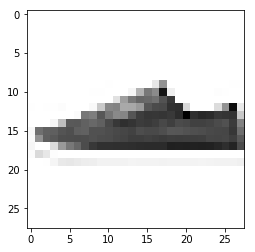

In [4]:
# An example from the dataset
image = X_train.iloc[np.random.randint(len(X_train))].values.reshape(28,28)
plt.imshow(image, cmap = 'binary')

## Preprocess the data

In [5]:
# Normalize the data and make them numpy arrays
X_train = X_train.values / 255
X_test = X_test.values / 255

In [6]:
# Reshape X_train and X_test to have the shape of the image
X_train_image = X_train.reshape(-1, 28, 28, 1)
X_test_image = X_test.reshape(-1, 28, 28, 1)

## Building our model on TensorFlow
___
Build our model using tf.name_scope to organize the model graph, and tf.summary to display the graph, scalars, histograms, distributions and images on TensorBoard. Note that when predicting accuracy on the test set I only use 1000 examples because of lack of memory.

In [7]:
# Define a function that creates mini-batches
def mini_batch(X, y, batch_size):
    batches = []
    batch_count = int(X.shape[0] / batch_size)
    
    permutation = np.random.permutation(X.shape[0])
    X_shuffled = X[permutation, :]
    y_shuffled = y[permutation]
    
    for i in range(batch_count):
        x_batch = X_shuffled[i*batch_size:i*batch_size+batch_size, :]
        y_batch = y_shuffled[i*batch_size:i*batch_size+batch_size]
        batch = [x_batch, y_batch]
        batches.append(batch)
    
    if (X.shape[0] % batch_size) != 0:
        x_batch = X_shuffled[batch_count*batch_size:, :]
        y_batch = y_shuffled[batch_count*batch_size:]
        batch = [x_batch, y_batch]
        batches.append(batch)
    
    return batches

In [8]:
# Define parameter initialization functions
def weight_variable(shape):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name='W')

def bias_variable(shape):
    return tf.Variable(tf.zeros(shape), name='b')

In [9]:
# Define a convolutional layer
def conv_layer(input, size_in, size_out, name='conv'):
    with tf.name_scope(name):
        W = weight_variable([3, 3, size_in, size_out])
        b = bias_variable([size_out])
        Z = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='VALID') + b
        A = tf.nn.relu(Z, name='A')
        
        # Parameters and activations show up in the TensorBoard histogram
        tf.summary.histogram('weights', W)
        tf.summary.histogram('biases', b)
        tf.summary.histogram('activations', A)        
        return A

# Define a max-pooling layer
def max_pool(input, name='maxpool'):
    with tf.name_scope(name):
        out = tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')        
        return out

# Define a fully-connected layer
def fc_layer(input, size_in, size_out, name='fc', act=None):
    with tf.name_scope(name):
        W = weight_variable([size_in, size_out])
        b = bias_variable([size_out])
        Z = tf.matmul(input, W) + b
        if act == 'relu':
            A = tf.nn.relu(Z, name='A')
        else:
            A = Z
        
        # Parameters and activations show up in the TensorBoard histogram
        tf.summary.histogram('weights', W)
        tf.summary.histogram('biases', b)
        tf.summary.histogram('activations', A)       
        return A
        

In [10]:
# Set the logging directory
LOGDIR = r'C:\Users\Marvin\Desktop\MachineLearning\Code\logs\FashionMNIST_tf'

In [11]:
### Building and training the ConvNet

# Reset graph
tf.reset_default_graph()

# Placeholders
X = tf.placeholder(tf.float32, [None, 784], name='X')
X_image = tf.reshape(X, [-1, 28, 28, 1])
y = tf.placeholder(tf.int64, [None], name='y')

# summary to display images in TensorBoard
tf.summary.image('input', X_image)

# Model
conv1 = conv_layer(X_image, 1, 32, 'conv1')
conv2 = conv_layer(conv1, 32, 64, 'conv2')
maxpool2 = max_pool(conv2, 'maxpool2')
conv3 = conv_layer(maxpool2, 64, 128, 'conv3')
conv4 = conv_layer(conv3, 128, 128, 'conv4')
maxpool4 = max_pool(conv4, 'maxpool4')
flatten = tf.reshape(maxpool4, [-1, 4 * 4 * 128], 'flatten')
fc5 = fc_layer(flatten, 4 * 4 * 128, 1024, 'fc5', 'relu')
logits = fc_layer(fc5, 1024, 10, 'fc6')


# Cross-entropy
with tf.name_scope('cross_entropy'):
    xent = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=y)
    tf.summary.scalar('cross_entropy', xent) # summary to display cross-entropy

# Training step
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(1e-3).minimize(xent)

# Accuracy
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy) # summary to display accuracy

# Merge all summaries
merged = tf.summary.merge_all()

# Create FileWriters to write in summaries and model graph
train_writer = tf.summary.FileWriter(LOGDIR + r'\train')
test_writer = tf.summary.FileWriter(LOGDIR + r'\test')


with tf.Session() as sess:
    # Write in the graph
    train_writer.add_graph(sess.graph)
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Training
    step = 0
    for i in range(3): # num epochs
        batches = mini_batch(X=X_train, y=y_train, batch_size=128)
        
        for batch in batches:    
            if step % 10 == 0: # Record summaries and print test set accuracy
                summary, acc = sess.run([merged, accuracy], feed_dict={X: X_test[:1000,:], y: y_test[:1000]})
                test_writer.add_summary(summary, step)
                print('Test accuracy at step %s: %s' % (step, acc))
            else:
                summary, _ = sess.run([merged, train_step], feed_dict={X: batch[0], y: batch[1]})
                train_writer.add_summary(summary, step)
            
            step += 1
            
    

Test accuracy at step 0: 0.038
Test accuracy at step 10: 0.655
Test accuracy at step 20: 0.682
Test accuracy at step 30: 0.741
Test accuracy at step 40: 0.766
Test accuracy at step 50: 0.749
Test accuracy at step 60: 0.787
Test accuracy at step 70: 0.787
Test accuracy at step 80: 0.793
Test accuracy at step 90: 0.794
Test accuracy at step 100: 0.802
Test accuracy at step 110: 0.807
Test accuracy at step 120: 0.818
Test accuracy at step 130: 0.82
Test accuracy at step 140: 0.823
Test accuracy at step 150: 0.834
Test accuracy at step 160: 0.809
Test accuracy at step 170: 0.838
Test accuracy at step 180: 0.848
Test accuracy at step 190: 0.839
Test accuracy at step 200: 0.848
Test accuracy at step 210: 0.842
Test accuracy at step 220: 0.867
Test accuracy at step 230: 0.841
Test accuracy at step 240: 0.866
Test accuracy at step 250: 0.864
Test accuracy at step 260: 0.874
Test accuracy at step 270: 0.863
Test accuracy at step 280: 0.876
Test accuracy at step 290: 0.856
Test accuracy at step 

Now just open up a command prompt and type: Tensorboard --logdir *"Insert your LOGDIR here"*

And open the address that's returned in a new tab.